Feature Engineering at NYC Data Science Academy

Jing Guo http://www.columbia.edu/~jg3222/

July 5th

Kaggle Competition: 

Two Sigma Connect: Rental Listing Inquiries
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

Final submission deadline: April 25, 2017

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
%matplotlib inline
%pylab inline
sns.set_style("whitegrid")
from sklearn import preprocessing


Populating the interactive namespace from numpy and matplotlib


In [5]:
X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")
print(X_train.shape)
X_train.head(5)

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


This dataset looks interesting. It has numerical features, categorical features, date feature, text features and image features.

Let us first have a look at the target variable 'interest level'.

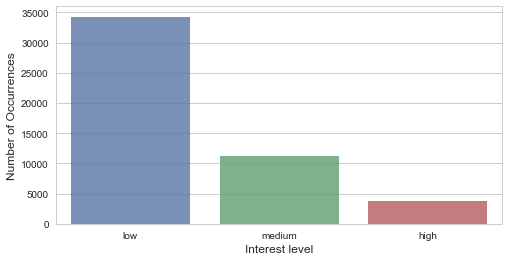

In [8]:
int_level = X_train['interest_level'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(int_level.index, int_level.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interest level', fontsize=12)
plt.show()

In [ ]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1

Interest level is low for most of the cases followed by medium and then high which makes sense.

Now let us start looking into the numerical features present in the dataset. Numerical features are

 - bathrooms
 - bedrooms
 - price
 - latitude
 - longitude

The last two are actually not numerical variables, but for now let us just consider it to be numerical.

Bathrooms

Let us first start with bathrooms.

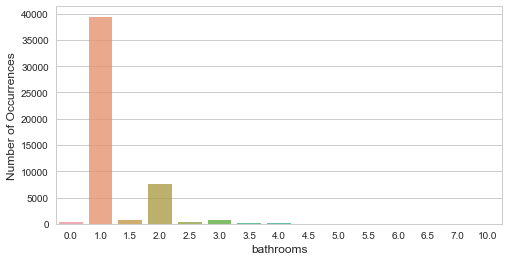

In [19]:
cnt_srs = X_train['bathrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)
plt.show()

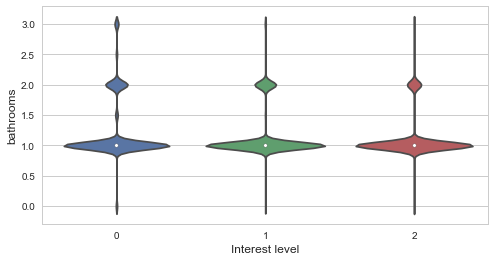

In [22]:
X_train['bathrooms'].ix[X_train['bathrooms']>3] = 3
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bathrooms', data=X_train)
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bathrooms', fontsize=12)
plt.show()

Looks like evenly distributed across the interest levels. Now let us look at the next feature 'bedrooms'.
Bedrooms:

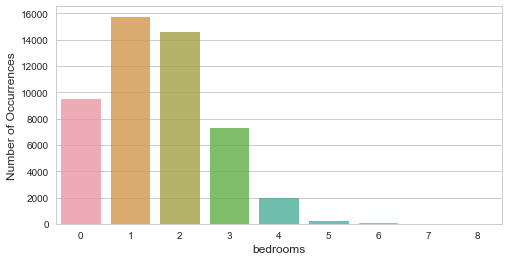

In [26]:
cnt_srs = X_train['bedrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.show()

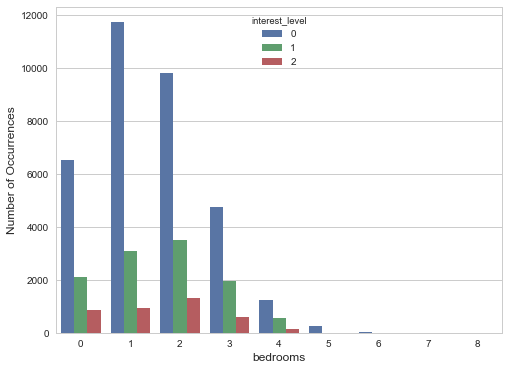

In [28]:
plt.figure(figsize=(8,6))
sns.countplot(x='bedrooms', hue='interest_level', data=X_train)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.show()

Price:
Now let us look at the price variable distribution.

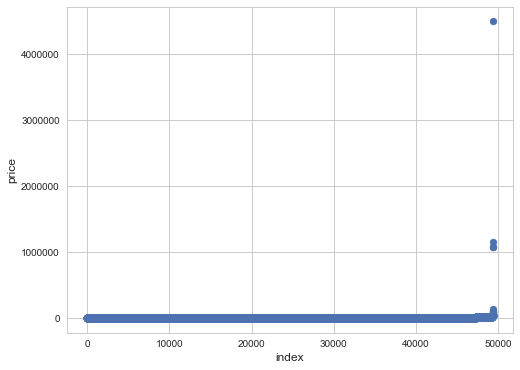

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(range(X_train.shape[0]), np.sort(X_train.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

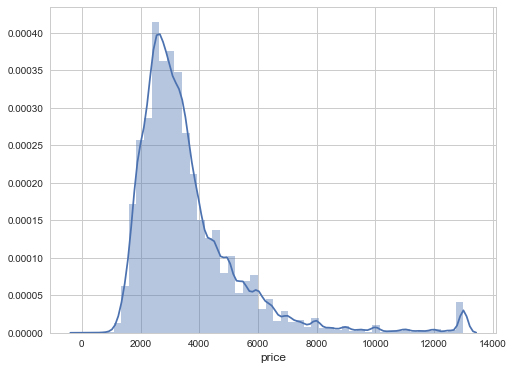

In [31]:
ulimit=X_train.price.quantile(.99)
X_train['price'].ix[X_train['price']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(X_train.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

The apartment renting website is:
https://www.renthop.com/

Let us search for the mechanism of the web.

If the street name is not provided, we will definitely be less interested in the apartment. Let us see whether providing the street address of the apartment makes a difference.

In [12]:
X_train['display_address']=X_train['display_address'].apply(lambda x: x.strip().lower())
X_train['IsStreetName']=X_train['display_address'].apply(lambda x: ('avenue' in x)|
                                                         ('street' in x)|('st' in x)|('ave' in x))

In [13]:
X_train['street_address']=X_train['street_address'].apply(lambda x: x.strip().lower())
X_train['IsStreetName2']=X_train['street_address'].apply(lambda x: ('avenue' in x)|
                                                         ('street' in x)|('st' in x)|('ave' in x))

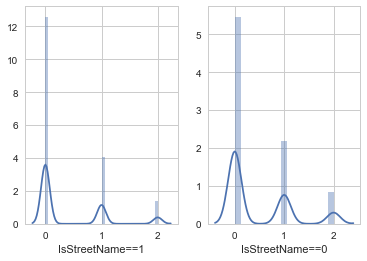

In [14]:
sns.distplot(X_train[X_train['IsStreetName2']==True]['interest_level'],ax=plt.subplot(121));
plt.xlabel('IsStreetName==1');
sns.distplot(X_train[X_train['IsStreetName2']==False]['interest_level'],ax=plt.subplot(122));
plt.xlabel('IsStreetName==0');

There is an option 'Has Photos' on the web. Let us see whether providing the photos of the apartment makes a difference.

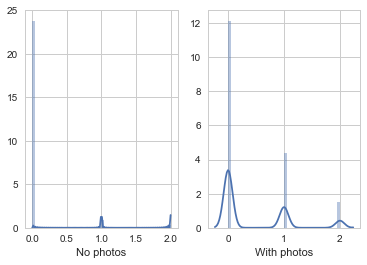

In [44]:
sns.distplot(X_train[X_train['photos'].apply(lambda x: len(x)==0)]['interest_level'],ax=plt.subplot(121));
plt.xlabel('No photos');
sns.distplot(X_train[X_train['photos'].apply(lambda x: len(x)>0)]['interest_level'],ax=plt.subplot(122));
plt.xlabel('With photos');

We have the detailed time when an apartment info is created. Let us see whether we can figure some out of it.

In [15]:
X_train['created']=pd.to_datetime(X_train['created'])
start=X_train['created'].describe()['first']
X_train['created_diff']=X_train['created'].apply(lambda x: (x-start).days)
X_train["created_month"] = X_train["created"].dt.month
X_train["created_day"] = X_train["created"].dt.day
X_train["created_hour"] = X_train["created"].dt.hour

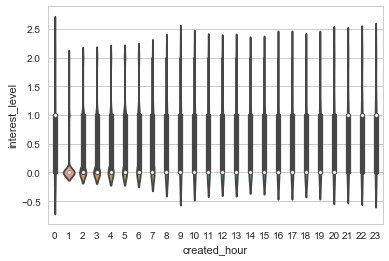

In [16]:
sns.violinplot(y='interest_level',x='created_hour',data=X_train)

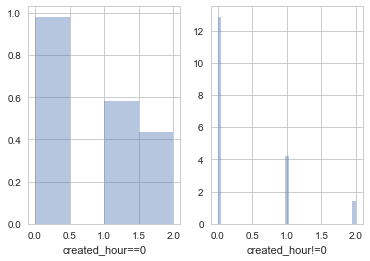

In [42]:
sns.distplot(X_train[X_train['created_hour']==0]['interest_level'],kde=0, norm_hist=1, ax=plt.subplot(121));
plt.xlabel('created_hour==0');
sns.distplot(X_train[X_train['created_hour']!=0]['interest_level'],kde=0, norm_hist=1, ax=plt.subplot(122));
plt.xlabel('created_hour!=0');

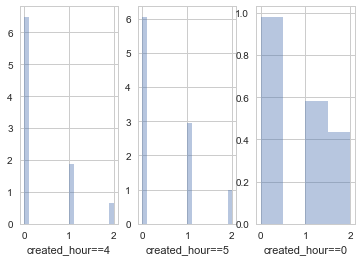

In [36]:
sns.distplot(X_train[X_train['created_hour']==4]['interest_level'],kde=0, norm_hist=1, ax=plt.subplot(131));
plt.xlabel('created_hour==4');
# axes=plt.gca()
# axes.set_ylim([0,8])
sns.distplot(X_train[X_train['created_hour']==5]['interest_level'],kde=0, norm_hist=1,ax=plt.subplot(132));
plt.xlabel('created_hour==5');
# axes=plt.gca()
# axes.set_ylim([0,8])
sns.distplot(X_train[X_train['created_hour']==0]['interest_level'],kde=0, norm_hist=1,ax=plt.subplot(133));
plt.xlabel('created_hour==0');
# axes=plt.gca()
# axes.set_ylim([0,8])

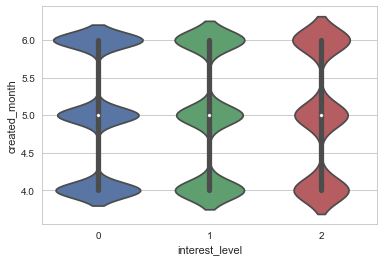

In [9]:
sns.violinplot(x='interest_level',y='created_month',data=X_train)


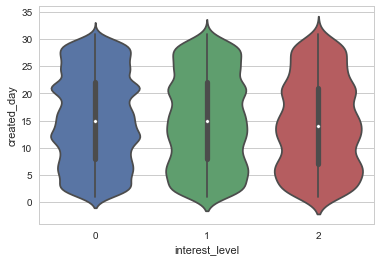

In [10]:
sns.violinplot(x='interest_level',y='created_day',data=X_train)

Inituitively, the popularity of an apartment should be related to its distance to the nearest subway station. We can find the longitude and latitude of all the NYC subway stations from the following website:

http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv

In [3]:
tmpdf=pd.read_csv('dist_to_subway_train.csv')
tmpdf.describe()

,dist_to_subway
count,49352.000000
mean,0.027349
std,1.334583
min,0.000046
25%,0.002015
50%,0.003236
75%,0.005195
max,84.193492


In [9]:
def readDist(X=X_train, name='train'):
    df=pd.read_csv("dist_to_subway_"+name+".csv")
    df.index=X.index
    X['dist_to_subway']=df['dist_to_subway']
    del df
readDist(X_train, 'train')
readDist(X_test,'test')

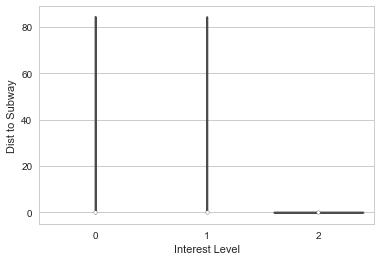

In [10]:
sns.violinplot(x="interest_level", y="dist_to_subway", order=[0, 1 ,2],
            data=X_train)
plt.xlabel('Interest Level');
plt.ylabel('Dist to Subway');

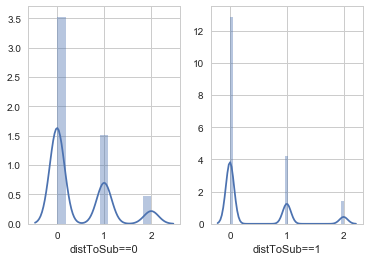

In [11]:
sns.distplot(X_train[X_train['dist_to_subway']>.01]['interest_level'],ax=plt.subplot(121));
plt.xlabel('distToSub==0');
sns.distplot(X_train[X_train['dist_to_subway']<.01]['interest_level'],ax=plt.subplot(122));
plt.xlabel('distToSub==1');
# sns.distplot(X_train[X_train['dist_to_subway']==2]['interest_level'],ax=plt.subplot(133));
# plt.xlabel('distToSub==2');

From the structure of the web, it is easy to assume that the interest level of an apartment strongly depends on the city/borough it lies in.

We can re-constructure the city of the apartment, given the longitude and latitude of the place, by the following python package. 
https://pypi.python.org/pypi/reverse_geocoder/

In [9]:
def addCity(X=X_train, name='train'):
    df=pd.read_csv("city_"+name+".csv")
    df.index=X.index
    X['city']=df['city']
    del df
addCity(X_train, 'train')
a=X_train.groupby('city').count().sort(['bedrooms'])['bedrooms']
print(len(a))
print(a[-10:])

63
city
Borough of Queens      484
East New York          491
Guttenberg             673
Inwood                1086
Edgewater             1280
Brooklyn              1782
Weehawken             3613
Long Island City      8980
New York City        14107
Manhattan            15510
Name: bedrooms, dtype: int64


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


Index([u'Borough of Queens', u'East New York', u'Guttenberg', u'Inwood',
       u'Edgewater', u'Brooklyn', u'Weehawken', u'Long Island City',
       u'New York City', u'Manhattan'],
      dtype='object', name=u'city')

(-74.02, -73.9)

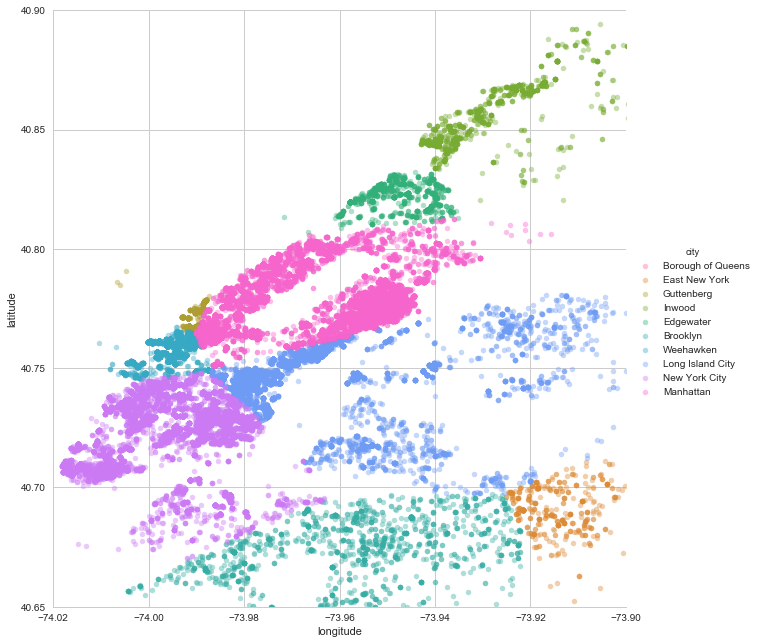

In [53]:
sns.lmplot(x="longitude", y="latitude", scatter_kws={'alpha':.4,'s':30}, \
           size=9, fit_reg=False, hue="city", hue_order=a, \
           data=X_train[:])
axes=plt.gca()
axes.set_ylim([40.65,40.9])
axes.set_xlim([-74.02, -73.9])

(0, 3)

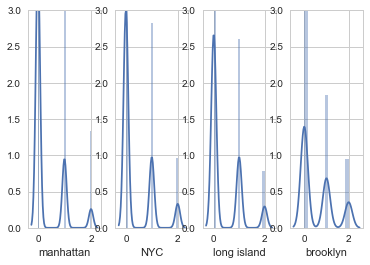

In [54]:
sns.distplot(X_train[X_train['city']=='Manhattan']['interest_level'],ax=plt.subplot(141));
plt.xlabel('manhattan');
axes=plt.gca()
axes.set_ylim([0,3])
sns.distplot(X_train[X_train['city']=='New York City']['interest_level'],ax=plt.subplot(142));
plt.xlabel('NYC');
axes=plt.gca()
axes.set_ylim([0,3])
sns.distplot(X_train[X_train['city']=='Long Island City']['interest_level'],ax=plt.subplot(143));
plt.xlabel('long island');
axes=plt.gca()
axes.set_ylim([0,3])
sns.distplot(X_train[X_train['city']=='Brooklyn']['interest_level'],ax=plt.subplot(144));
plt.xlabel('brooklyn');
axes=plt.gca()
axes.set_ylim([0,3])

(-74.05, -73.9)

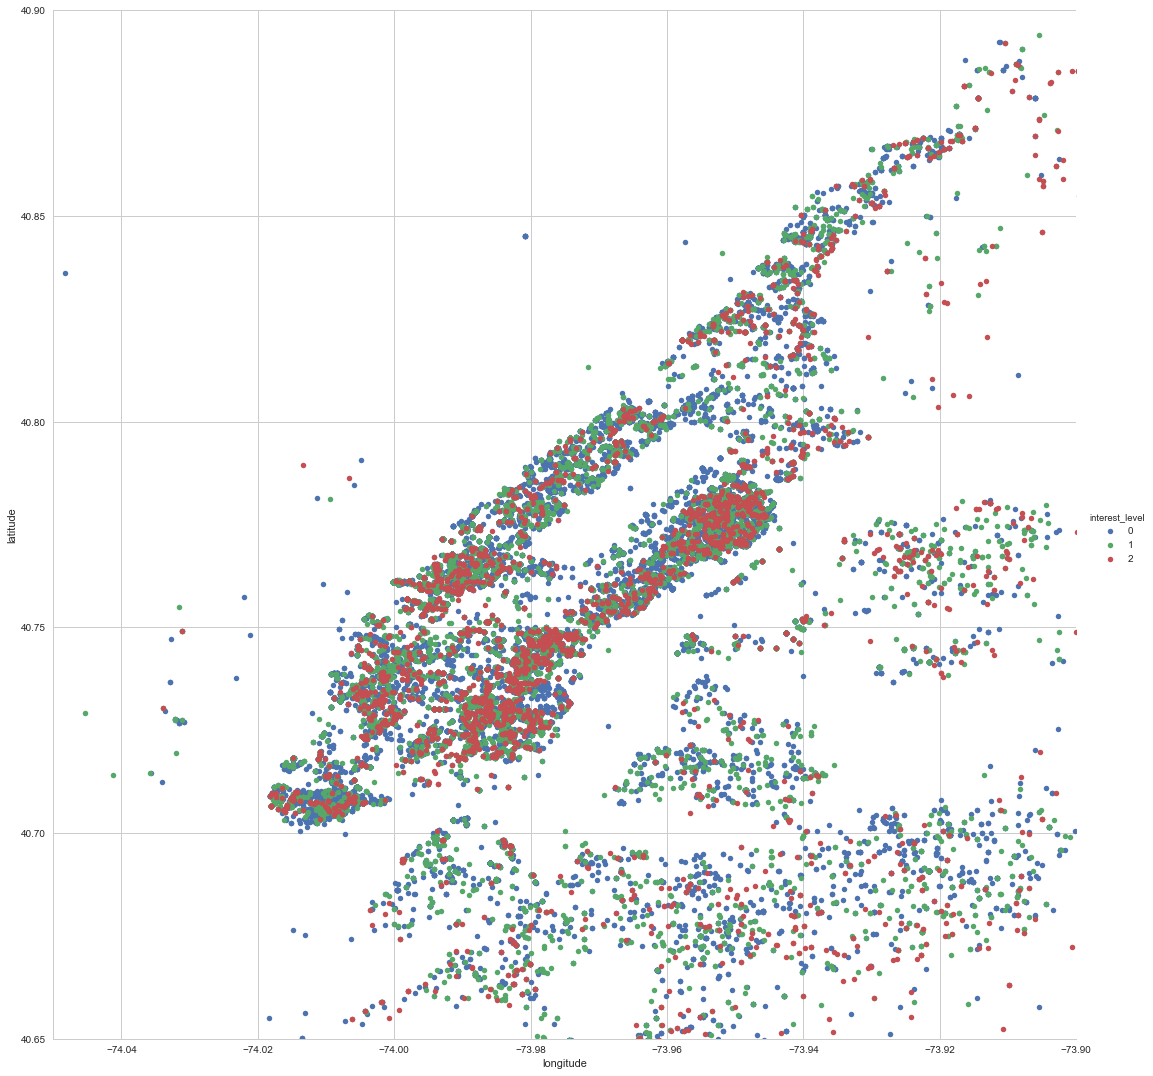

In [11]:
sns.lmplot(x="longitude", y="latitude", scatter_kws={'alpha':1,'s':30}, size=15, fit_reg=False, hue="interest_level",
           hue_order=[0,1,2], data=X_train[:].sample(frac=1))
axes=plt.gca()
# axes.set_ylim([40.70,40.82])
# axes.set_xlim([-74.02, -73.94])
axes.set_ylim([40.65,40.9])
axes.set_xlim([-74.05, -73.9])

Finally, Let us run a preliminary classifier with RandomForestClassifier

In [39]:
df = X_train
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
df["created_hour"] = df["created"].dt.hour

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", 
                   "created_month", 
                   "created_day",
                   #"dist_to_subway"
                  ]



def preProcess(label='manager_id'):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[label].values))
    df[label] = lbl.transform(list(df[label].values))

# for i in ['manager_id','borough','countyNum'#,'city'
#          ]:
#     preProcess(i)
#     features_to_use.append(i)

0.642293185615


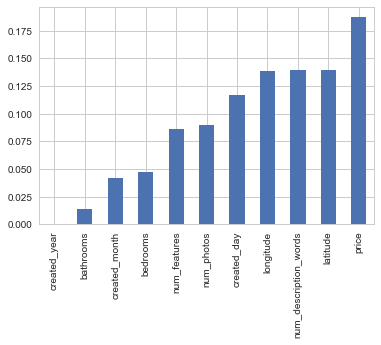

In [40]:
from sklearn.ensemble import RandomForestClassifier
X = df[features_to_use]
y = df["interest_level"]
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.33, random_state=15)
these_features = [f for f in features_to_use if f not in [#'manager_id', 
                                                          'countyNum',
                                                          'county','borough','city',\
                                                          'high_frac_manager_id',\
                                                          #'low_frac_manager_id', 'medium_frac_manager_id',
                                                          'high_frac_city','low_frac_city', 'medium_frac_city',
                                                          'high_frac_borough','low_frac_borough', 
                                                          'medium_frac_borough',
                                                          'high_frac_countyNum','low_frac_countyNum', 
                                                          'medium_frac_countyNum',
                                                          #'longitude', 'latitude',
                                                         #'dist_to_subway'
                                                          ]]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(Xtrain[these_features], ytrain)
yval_pred = clf.predict_proba(Xval[these_features])
print(log_loss(yval, yval_pred))
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')